In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F
import argparse
import matplotlib
from tqdm import tqdm
import glob
from PIL import Image
import os
from datetime import datetime
import time
import math
import sys
sys.path.append("../../src")
from ContrastiveModels import *
from visualization import *

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), 
                                            std=(3*0.2023, 3*0.1994, 3*0.2010))])

cifar_dset_train = torchvision.datasets.CIFAR10('../../data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(cifar_dset_train, batch_size=20, shuffle=True, num_workers=0)

cifar_dset_test = torchvision.datasets.CIFAR10('../../data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(cifar_dset_test, batch_size=20, shuffle=False, num_workers=0)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../../data/cifar-10-python.tar.gz to ../../data
Files already downloaded and verified


In [4]:
activation = hard_sigmoid
criterion = torch.nn.MSELoss(reduction='none').to(device)
architecture = [int(32*32*3), 500, 10]
model = EP(architecture, activation = activation)

In [5]:
lrs = [0.1, 0.05]

In [6]:
optim_params = []
for idx in range(len(model.W)):
    optim_params.append(  {'params': model.W[idx].parameters(), 'lr': lrs[idx]}  )

In [7]:
optimizer = torch.optim.SGD( optim_params, momentum=0.0 )

In [8]:
model = model.to(device)
evaluateEP(model, test_loader, 20, 0.5, device)

Test accuracy :	 0.1162


0.1162

In [9]:
mbs = train_loader.batch_size
start = time.time()
iter_per_epochs = math.ceil(len(train_loader.dataset)/mbs)
betas = (0.0, 1.0)
beta_1, beta_2 = betas
neural_lr = 0.5
train_acc = [10.0]
test_acc = [10.0]
best = 0.0
epoch_sofar = 0
model.train();

In [10]:
trn_acc_list = []
tst_acc_list = []
T1 = 20
T2 = 4
random_sign = True
n_epochs = 25
for epoch_ in range(n_epochs):
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        neurons = model.init_neurons(x.size(0), device)
        neurons = model(x, y, neurons, T1, neural_lr, beta=beta_1, criterion=criterion)
        neurons_1 = copy(neurons)
        if random_sign and (beta_1==0.0):
            rnd_sgn = 2*np.random.randint(2) - 1
            betas = beta_1, rnd_sgn*beta_2
            beta_1, beta_2 = betas

        neurons = model(x, y, neurons, T2, neural_lr, beta = beta_2, criterion=criterion)
        neurons_2 = copy(neurons)
        model.compute_syn_grads(x, y, neurons_1, neurons_2, betas, criterion)
        optimizer.step() 
    trn_acc = evaluateEP(model.to(device), train_loader, T1, neural_lr, device, False)
    tst_acc = evaluateEP(model.to(device), test_loader, T1, neural_lr, device, False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))

2500it [01:06, 37.74it/s]
4it [00:00, 33.92it/s]

Epoch : 1, Train Accuracy : 0.45972, Test Accuracy : 0.4307


2500it [01:07, 37.29it/s]
4it [00:00, 33.80it/s]

Epoch : 2, Train Accuracy : 0.46796, Test Accuracy : 0.4334


2500it [01:14, 33.43it/s]
4it [00:00, 32.28it/s]

Epoch : 3, Train Accuracy : 0.48956, Test Accuracy : 0.452


2500it [01:08, 36.26it/s]
4it [00:00, 34.41it/s]

Epoch : 4, Train Accuracy : 0.49478, Test Accuracy : 0.4375


2500it [01:07, 37.01it/s]
4it [00:00, 33.99it/s]

Epoch : 5, Train Accuracy : 0.55112, Test Accuracy : 0.4788


2500it [01:09, 36.03it/s]
4it [00:00, 33.76it/s]

Epoch : 6, Train Accuracy : 0.49902, Test Accuracy : 0.4335


2500it [01:08, 36.29it/s]
4it [00:00, 33.97it/s]

Epoch : 7, Train Accuracy : 0.5918, Test Accuracy : 0.4961


2500it [01:09, 36.08it/s]
4it [00:00, 34.77it/s]

Epoch : 8, Train Accuracy : 0.58738, Test Accuracy : 0.4862


2500it [01:08, 36.60it/s]
4it [00:00, 32.78it/s]

Epoch : 9, Train Accuracy : 0.57992, Test Accuracy : 0.4769


2500it [01:10, 35.31it/s]
4it [00:00, 34.54it/s]

Epoch : 10, Train Accuracy : 0.61374, Test Accuracy : 0.4828


2500it [01:08, 36.30it/s]
4it [00:00, 34.33it/s]

Epoch : 11, Train Accuracy : 0.60478, Test Accuracy : 0.4823


2500it [01:07, 37.13it/s]
2it [00:00, 18.73it/s]

Epoch : 12, Train Accuracy : 0.61562, Test Accuracy : 0.4786


2500it [01:58, 21.09it/s]
2it [00:00, 19.94it/s]

Epoch : 13, Train Accuracy : 0.63546, Test Accuracy : 0.493


2500it [01:57, 21.23it/s]
2it [00:00, 19.68it/s]

Epoch : 14, Train Accuracy : 0.64112, Test Accuracy : 0.4884


2500it [01:58, 21.05it/s]
3it [00:00, 20.17it/s]

Epoch : 15, Train Accuracy : 0.67022, Test Accuracy : 0.5019


2500it [01:58, 21.17it/s]
2it [00:00, 19.87it/s]

Epoch : 16, Train Accuracy : 0.65938, Test Accuracy : 0.4946


2500it [01:58, 21.04it/s]
2it [00:00, 17.74it/s]

Epoch : 17, Train Accuracy : 0.6677, Test Accuracy : 0.4831


2500it [01:58, 21.08it/s]
2it [00:00, 19.85it/s]

Epoch : 18, Train Accuracy : 0.70532, Test Accuracy : 0.5089


2500it [01:58, 21.11it/s]
2it [00:00, 17.11it/s]

Epoch : 19, Train Accuracy : 0.70774, Test Accuracy : 0.5117


2500it [01:21, 30.69it/s]
4it [00:00, 34.13it/s]

Epoch : 20, Train Accuracy : 0.69566, Test Accuracy : 0.4803


2500it [01:07, 36.80it/s]
4it [00:00, 33.77it/s]

Epoch : 21, Train Accuracy : 0.7039, Test Accuracy : 0.4859


2500it [01:08, 36.58it/s]
4it [00:00, 33.18it/s]

Epoch : 22, Train Accuracy : 0.73216, Test Accuracy : 0.4964


2500it [01:08, 36.32it/s]
4it [00:00, 33.45it/s]

Epoch : 23, Train Accuracy : 0.71126, Test Accuracy : 0.4817


2500it [01:09, 35.93it/s]
4it [00:00, 33.85it/s]

Epoch : 24, Train Accuracy : 0.72206, Test Accuracy : 0.4885


2500it [01:08, 36.69it/s]


Epoch : 25, Train Accuracy : 0.74264, Test Accuracy : 0.4948


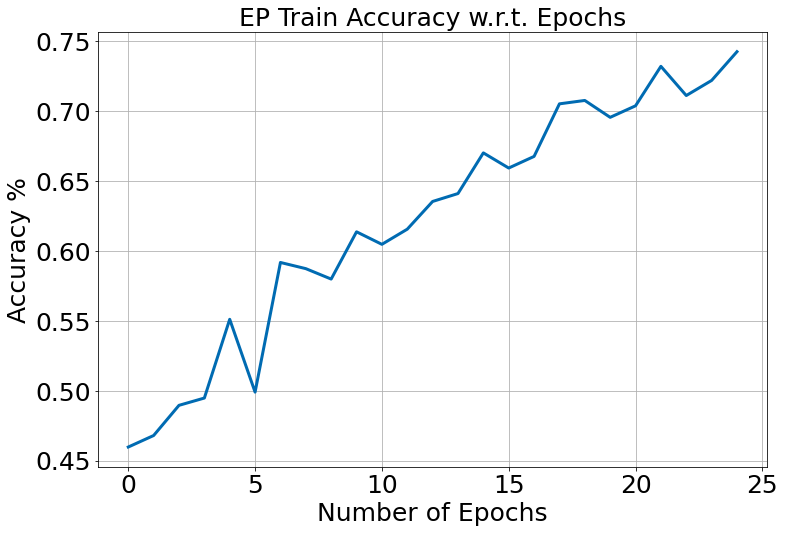

In [11]:
plot_convergence_plot(trn_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'EP Train Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

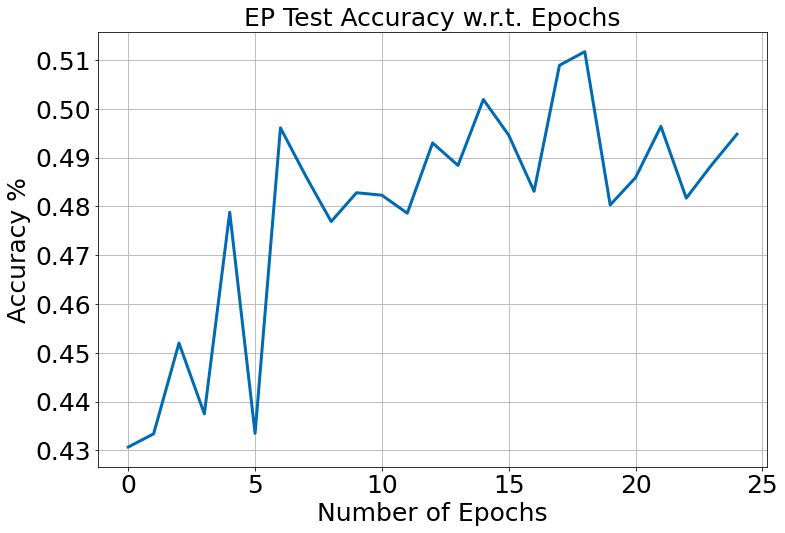

In [12]:
plot_convergence_plot(tst_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'EP Test Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

In [13]:
evaluateEP(model.to(device), test_loader, T1, neural_lr, device)

Test accuracy :	 0.4948


0.4948

In [14]:
evaluateEP(model.to(device), train_loader, T1, neural_lr, device)

Train accuracy :	 0.74264


0.74264